# U-Net Model - Orbital Response

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import torch
from torchvision import transforms
import torchvision.models as models

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import functional as TF
import torch.optim as optim
from torchsummary import summary
from torch.nn.functional import one_hot
from torchvision import models

from torchmetrics.segmentation import GeneralizedDiceScore

from PIL import Image
from tqdm import tqdm

import albumentations as A
from albumentations.pytorch import ToTensorV2

from copy import deepcopy

## Model Initialisation

### The Encoder

In [2]:
resnet34 = models.resnet34(pretrained=True)

/home/chris/.pyenv/versions/3.10.6/envs/orbital-response/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/chris/.pyenv/versions/3.10.6/envs/orbital-response/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
resnet34.conv1 = nn.Conv2d(
    in_channels=7,   # 6 for pre + post RGB images
    out_channels=64,
    kernel_size=7,
    stride=2,
    padding=3,
    bias=False
)

In [4]:
############### Train the whole model, not freezing ###############
for param in resnet34.parameters():
    param.requires_grad = True

### The Decoder

In [5]:
#convolution block
def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(out_channels),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(out_channels)
    )

### Combining the Decoder to Form the U-Net

In [6]:
############### UNET Binary WITH DROPOUTS ###############
# Defining the U-Net model class
class UNetBinaryDetector(nn.Module):
    def __init__(self, n_classes=1):
        super().__init__()

        self.encoder = resnet34
        self.up5 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec5 = conv_block(256 + 256, 256)

        self.up4 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec4 = conv_block(128 + 128, 128)

        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec3 = conv_block(64 + 64, 64)
        

        self.up2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec2 = conv_block(32 + 64, 64)

        self.up1 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.final_conv = nn.Conv2d(64, n_classes, kernel_size=1)

        self.dropout = nn.Dropout2d(0.4)

    def forward(self, x):
        assert x.shape[1] == 7, f"Expected 7 channels, got {x.shape[1]}"

        # Encoder
        e1 = self.encoder.relu(self.encoder.bn1(self.encoder.conv1(x)))  # 64
        e2 = self.encoder.layer1(self.encoder.maxpool(e1))  # 64
        e3 = self.encoder.layer2(e2)  # 128
        e4 = self.encoder.layer3(e3)  # 256
        e5 = self.encoder.layer4(e4)  # 512

        # Decoder
        d5 = self.dropout(self.dec5(torch.cat([self.up5(e5), e4], dim=1)))
        d4 = self.dropout(self.dec4(torch.cat([self.up4(d5), e3], dim=1)))
        d3 = self.dropout(self.dec3(torch.cat([self.up3(d4), e2], dim=1)))
        d2 = self.dropout(self.dec2(torch.cat([self.up2(d3), e1], dim=1)))
        d1 = self.up1(d2)

        out = self.final_conv(d1)
        return F.interpolate(out, size=x.shape[2:], mode='bilinear', align_corners=False)

## Dataset and DataLoader

In [7]:
class MaskTransform:
    def __init__(self, size=(1024, 1024)):
        self.size = size

    def __call__(self, mask):
        mask = TF.resize(mask, self.size, interpolation=transforms.InterpolationMode.NEAREST)
        mask_np = np.array(mask)
        #no dmg and 0 is now 0
        mask_bin = (mask_np >= 2).astype(np.uint8)
        return torch.from_numpy(mask_bin).long() #lng tensor

In [8]:
mask_transform = MaskTransform(size=(1024, 1024))

In [9]:
class PrimaryDataset(Dataset):
    def __init__(self, root_dir, mask_transform=None, include_building_mask=True):
        self.image_dir = os.path.join(root_dir, "images")
        self.mask_dir = os.path.join(root_dir, "masks")
        self.include_building_mask = include_building_mask
        self.mask_transform = mask_transform

        self.building_mask_dir = os.path.join(root_dir, "building_masks") if include_building_mask else None

        self.resize = transforms.Resize((1024, 1024))
        self.to_tensor = transforms.ToTensor() #[0,1]

        self.normalize_7_channels = transforms.Normalize(
            mean=[0.485, 0.456, 0.406, 0.485, 0.456, 0.406, 0.5],
            std=[0.229, 0.224, 0.225, 0.229, 0.224, 0.225, 0.25]
        )

        all_mask_files = os.listdir(self.mask_dir)
        self.ids = sorted(set(
            f.replace("_pre_disaster_mask.png", "").replace("_post_disaster_mask.png", "")
            for f in all_mask_files if f.endswith(".png")
        ))

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        image_id = self.ids[idx]

        # Rutes
        pre_img_path = os.path.join(self.image_dir, f"{image_id}_pre_disaster.png")
        post_img_path = os.path.join(self.image_dir, f"{image_id}_post_disaster.png")
        mask_img_path = os.path.join(self.mask_dir, f"{image_id}_post_disaster_mask.png")

        # load images ipl
        pre_img = Image.open(pre_img_path).convert("RGB")
        post_img = Image.open(post_img_path).convert("RGB")
        mask_img = Image.open(mask_img_path)

        # Transform
        pre_tensor = self.to_tensor(self.resize(pre_img))   # [3, H, W], to  [0,1]
        post_tensor = self.to_tensor(self.resize(post_img)) # [3, H, W], to  [0,1]

        # Concat pre post (6 chan)
        image_for_model = torch.cat([pre_tensor, post_tensor], dim=0) # [6, H, W]

        building_mask_original_binary = None

        if self.include_building_mask:
            building_path = os.path.join(self.building_mask_dir, f"{image_id}_building_mask.png")
            building_img = Image.open(building_path).convert("L")

            building_mask_original_binary = transforms.ToTensor()(self.resize(building_img)) # [1, H, W]
            building_mask_original_binary = (building_mask_original_binary > 0).float().squeeze(0) # [H, W] (0.0 o 1.0)

            building_tensor_for_model = transforms.ToTensor()(self.resize(building_img)) # [1, H, W]

            image_for_model = torch.cat([image_for_model, building_tensor_for_model], dim=0) # [7, H, W]

        image_for_model = self.normalize_7_channels(image_for_model)

        if self.mask_transform:
            mask_tensor = self.mask_transform(mask_img)
        else:
            mask_tensor = transforms.ToTensor()(self.resize(mask_img))
            mask_tensor = (mask_tensor >= 2).long().squeeze(0) #[H, W] long

        return image_for_model, mask_tensor, building_mask_original_binary


In [10]:
class SecondaryDataset(Dataset):
    def __init__(self, root_dir, mask_transform=None, include_building_mask=True):
        self.image_dir = os.path.join(root_dir, "images")
        self.mask_dir = os.path.join(root_dir, "masks")
        self.include_building_mask = include_building_mask
        self.mask_transform = mask_transform

        self.building_mask_dir = os.path.join(root_dir, "building_masks") if include_building_mask else None

        self.resize = transforms.Resize((1024, 1024))
        self.to_tensor = transforms.ToTensor() #[0,1]

        self.normalize_7_channels = transforms.Normalize(
            mean=[0.485, 0.456, 0.406, 0.485, 0.456, 0.406, 0.5],
            std=[0.229, 0.224, 0.225, 0.229, 0.224, 0.225, 0.25]
        )

        all_mask_files = os.listdir(self.mask_dir)
        self.ids = sorted(set(
            f.replace("_mask.png", "").replace("_mask.png", "")
            for f in all_mask_files if f.endswith(".png")
        ))

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        image_id = self.ids[idx]

        # Rutes
        pre_img_path = os.path.join(self.image_dir, f"{image_id}_pre_disaster.png")
        post_img_path = os.path.join(self.image_dir, f"{image_id}_post_disaster.png")
        mask_img_path = os.path.join(self.mask_dir, f"{image_id}_mask.png")

        # load images ipl
        pre_img = Image.open(pre_img_path).convert("RGB")
        post_img = Image.open(post_img_path).convert("RGB")
        mask_img = Image.open(mask_img_path)

        # Transform
        pre_tensor = self.to_tensor(self.resize(pre_img))   # [3, H, W], to  [0,1]
        post_tensor = self.to_tensor(self.resize(post_img)) # [3, H, W], to  [0,1]

        # Concat pre post (6 chan)
        image_for_model = torch.cat([pre_tensor, post_tensor], dim=0) # [6, H, W]

        building_mask_original_binary = None

        if self.include_building_mask:
            building_path = os.path.join(self.building_mask_dir, f"{image_id}_building_mask.png")
            building_img = Image.open(building_path).convert("L")

            building_mask_original_binary = transforms.ToTensor()(self.resize(building_img)) # [1, H, W]
            building_mask_original_binary = (building_mask_original_binary > 0).float().squeeze(0) # [H, W] (0.0 o 1.0)

            building_tensor_for_model = transforms.ToTensor()(self.resize(building_img)) # [1, H, W]

            image_for_model = torch.cat([image_for_model, building_tensor_for_model], dim=0) # [7, H, W]

        image_for_model = self.normalize_7_channels(image_for_model)

        if self.mask_transform:
            mask_tensor = self.mask_transform(mask_img)
        else:
            mask_tensor = transforms.ToTensor()(self.resize(mask_img))
            mask_tensor = (mask_tensor >= 2).long().squeeze(0) #[H, W] long

        return image_for_model, mask_tensor, building_mask_original_binary


## Model Training 

In [11]:
# Empty the torch cache, which may slow the training process
torch.cuda.empty_cache()

### Data Augmentation and Loading in the train, val and test data.

In [12]:
class AugmentedCropDataset(Dataset):
    def __init__(self, image_dir, mask_dir, building_mask_dir, crop_size=(224, 224), min_ratio=0.3, max_attempts=40):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.building_mask_dir = building_mask_dir
        self.crop_size = crop_size
        self.min_ratio = min_ratio
        self.max_attempts = max_attempts

        self.filenames = sorted([
            f for f in os.listdir(mask_dir)
            if f.endswith("_post_disaster_mask.png")
        ])

        self.augment = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.07, scale_limit=0.1, rotate_limit=5, p=0.7),
            A.RandomBrightnessContrast(p=0.25),
            A.GaussianBlur(p=0.15),
        ])

        self.to_tensor_and_normalize = A.Compose([
            A.Normalize(
                mean=(0.485, 0.456, 0.406, 0.485, 0.456, 0.406, 0.5),
                std=(0.229, 0.224, 0.225, 0.229, 0.224, 0.225, 0.25)
            ),

            ToTensorV2(transpose_mask=True),
        ])

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        base_name = self.filenames[idx].replace("_post_disaster_mask.png", "")
        pre_path = os.path.join(self.image_dir, f"{base_name}_pre_disaster.png")
        post_path = os.path.join(self.image_dir, f"{base_name}_post_disaster.png")
        mask_path = os.path.join(self.mask_dir, f"{base_name}_post_disaster_mask.png")
        build_mask_path = os.path.join(self.building_mask_dir, f"{base_name}_building_mask.png")

        #1024x1024
        pre = np.array(Image.open(pre_path).convert("RGB").resize((1024, 1024)))
        post = np.array(Image.open(post_path).convert("RGB").resize((1024, 1024)))
        mask = np.array(Image.open(mask_path).resize((1024, 1024), resample=Image.NEAREST))
        building = np.array(Image.open(build_mask_path).resize((1024, 1024), resample=Image.NEAREST))

        # (0 o 1)
        mask = (mask > 0.5).astype(np.uint8) # DMG mask
        building_mask_original_binary = (building > 127).astype(np.float32)

        # [H, W, 1]
        building_channel_for_model = (building > 127).astype(np.float32)[..., np.newaxis]

        # [H, W, 7]
        image_for_model = np.concatenate([pre, post, building_channel_for_model], axis=-1)

        h, w, _ = image_for_model.shape
        ch, cw = self.crop_size

        for _ in range(self.max_attempts):
            top = random.randint(0, h - ch)
            left = random.randint(0, w - cw)

            img_crop = image_for_model[top:top + ch, left:left + cw, :]
            mask_crop = mask[top:top + ch, left:left + cw]
            building_mask_original_binary_crop = building_mask_original_binary[top:top + ch, left:left + cw]

            damage_in_building = (mask_crop == 1) * (building_mask_original_binary_crop == 1)
            total_building_pixels_in_crop = np.sum(building_mask_original_binary_crop)
            
            # no div cero
            if total_building_pixels_in_crop > 0:
                ratio = np.sum(damage_in_building) / total_building_pixels_in_crop
            else:
                ratio = 0.0

            if ratio >= self.min_ratio:
                augmented = self.augment(image=img_crop, mask=mask_crop)
                aug_image = augmented["image"]
                aug_mask = augmented["mask"]

                final_transformed = self.to_tensor_and_normalize(image=aug_image, mask=aug_mask)
        
                return final_transformed["image"], final_transformed["mask"].long(), torch.from_numpy(building_mask_original_binary_crop).float()

        top = random.randint(0, h - ch)
        left = random.randint(0, w - cw)
        img_crop = image_for_model[top:top + ch, left:left + cw, :]
        mask_crop = mask[top:top + ch, left:left + cw]
        building_mask_original_binary_crop = building_mask_original_binary[top:top + ch, left:left + cw]

        augmented = self.augment(image=img_crop, mask=mask_crop)
        aug_image = augmented["image"]
        aug_mask = augmented["mask"]

        final_transformed = self.to_tensor_and_normalize(image=aug_image, mask=aug_mask)
        return final_transformed["image"], final_transformed["mask"].long(), torch.from_numpy(building_mask_original_binary_crop).float()


In [13]:
class AugmentedSecondaryCropDataset(Dataset):
    def __init__(self, image_dir, mask_dir, building_mask_dir, crop_size=(224, 224), min_ratio=0.3, max_attempts=40):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.building_mask_dir = building_mask_dir
        self.crop_size = crop_size
        self.min_ratio = min_ratio
        self.max_attempts = max_attempts

        self.filenames = sorted([
            f for f in os.listdir(mask_dir)
            if f.endswith("_mask.png")
        ])

        self.augment = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.07, scale_limit=0.1, rotate_limit=5, p=0.7),
            A.RandomBrightnessContrast(p=0.25),
            A.GaussianBlur(p=0.15),
        ])

        self.to_tensor_and_normalize = A.Compose([
            A.Normalize(
                mean=(0.485, 0.456, 0.406, 0.485, 0.456, 0.406, 0.5),
                std=(0.229, 0.224, 0.225, 0.229, 0.224, 0.225, 0.25)
            ),

            ToTensorV2(transpose_mask=True),
        ])

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        base_name = self.filenames[idx].replace("_mask.png", "")
        pre_path = os.path.join(self.image_dir, f"{base_name}_pre_disaster.png")
        post_path = os.path.join(self.image_dir, f"{base_name}_post_disaster.png")
        mask_path = os.path.join(self.mask_dir, f"{base_name}_mask.png")
        build_mask_path = os.path.join(self.building_mask_dir, f"{base_name}_building_mask.png")

        #1024x1024
        pre = np.array(Image.open(pre_path).convert("RGB").resize((1024, 1024)))
        post = np.array(Image.open(post_path).convert("RGB").resize((1024, 1024)))
        mask = np.array(Image.open(mask_path).resize((1024, 1024), resample=Image.NEAREST))
        building = np.array(Image.open(build_mask_path).resize((1024, 1024), resample=Image.NEAREST))

        # (0 o 1)
        mask = (mask > 0.5).astype(np.uint8) # DMG mask
        building_mask_original_binary = (building > 127).astype(np.float32)

        # [H, W, 1]
        building_channel_for_model = (building > 127).astype(np.float32)[..., np.newaxis]

        # [H, W, 7]
        image_for_model = np.concatenate([pre, post, building_channel_for_model], axis=-1)

        h, w, _ = image_for_model.shape
        ch, cw = self.crop_size

        for _ in range(self.max_attempts):
            top = random.randint(0, h - ch)
            left = random.randint(0, w - cw)

            img_crop = image_for_model[top:top + ch, left:left + cw, :]
            mask_crop = mask[top:top + ch, left:left + cw]
            building_mask_original_binary_crop = building_mask_original_binary[top:top + ch, left:left + cw]

            damage_in_building = (mask_crop == 1) * (building_mask_original_binary_crop == 1)
            total_building_pixels_in_crop = np.sum(building_mask_original_binary_crop)
            
            # no div cero
            if total_building_pixels_in_crop > 0:
                ratio = np.sum(damage_in_building) / total_building_pixels_in_crop
            else:
                ratio = 0.0

            if ratio >= self.min_ratio:
                augmented = self.augment(image=img_crop, mask=mask_crop)
                aug_image = augmented["image"]
                aug_mask = augmented["mask"]

                final_transformed = self.to_tensor_and_normalize(image=aug_image, mask=aug_mask)
        
                return final_transformed["image"], final_transformed["mask"].long(), torch.from_numpy(building_mask_original_binary_crop).float()

        top = random.randint(0, h - ch)
        left = random.randint(0, w - cw)
        img_crop = image_for_model[top:top + ch, left:left + cw, :]
        mask_crop = mask[top:top + ch, left:left + cw]
        building_mask_original_binary_crop = building_mask_original_binary[top:top + ch, left:left + cw]

        augmented = self.augment(image=img_crop, mask=mask_crop)
        aug_image = augmented["image"]
        aug_mask = augmented["mask"]

        final_transformed = self.to_tensor_and_normalize(image=aug_image, mask=aug_mask)
        return final_transformed["image"], final_transformed["mask"].long(), torch.from_numpy(building_mask_original_binary_crop).float()


In [14]:
from torch.utils.data import ConcatDataset
train_dataset = AugmentedCropDataset(
    image_dir="../data/filtered/split/train/images",
    mask_dir="../data/filtered/split/train/masks",
    building_mask_dir="../data/filtered/split/train/building_masks",
    crop_size=(224, 224),
    min_ratio=0.3
)

train_secondary_dataset = AugmentedSecondaryCropDataset(
    image_dir="../data/filtered/data_secondary/split/train/images",
    mask_dir="../data/filtered/data_secondary/split/train/masks",
    building_mask_dir="../data/filtered/data_secondary/split/train/building_masks",
    crop_size=(224, 224),
    min_ratio=0.1
)
combined_train_dataset = ConcatDataset([train_dataset, train_secondary_dataset])

/home/chris/.pyenv/versions/3.10.6/envs/orbital-response/lib/python3.10/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [15]:
val_dataset = PrimaryDataset(root_dir="../data/filtered/split/val", mask_transform=mask_transform, include_building_mask=True)
val_secondary_dataset = SecondaryDataset(root_dir="../data/filtered/data_secondary/split/val", mask_transform=mask_transform, include_building_mask=True)

combined_val_dataset = ConcatDataset([val_dataset, val_secondary_dataset])

test_dataset = PrimaryDataset(root_dir="../data/filtered/split/test", mask_transform=mask_transform, include_building_mask=True)
test_secondary_dataset = SecondaryDataset(root_dir="../data/filtered/data_secondary/split/test", mask_transform=mask_transform, include_building_mask=True)
combined_test_dataset = ConcatDataset([test_dataset, test_secondary_dataset])

In [ ]:
LEARNING_RATE = 1e-4
BATCH_SIZE = 4

num_workers = 12  # Adjust depending on cpu

train_dataloader = DataLoader(combined_train_dataset, 
                              batch_size=BATCH_SIZE, 
                              shuffle=True,
                              drop_last=True, 
                              num_workers=num_workers)

val_dataloader = DataLoader(combined_val_dataset, 
                            batch_size=BATCH_SIZE, 
                            shuffle=False,
                            num_workers=num_workers)

test_dataloader = DataLoader(combined_test_dataset, 
                             batch_size=BATCH_SIZE, 
                             shuffle=False,
                             num_workers=num_workers)

### Model initialisation, and defining model parameters.

In [17]:
mask_dirs = [
    "../data/filtered/split/train/masks",
    "../data/filtered/data_secondary/split/train/masks",
]
building_mask_dirs = [
    "../data/filtered/split/train/building_masks",
    "../data/filtered/data_secondary/split/train/building_masks",
]

total_pos = 0
total_neg = 0

for mdir in mask_dirs:
    for fname in tqdm(os.listdir(mdir), desc=f"Processing {mdir}"):
        if not (fname.endswith("_post_disaster_mask.png") or fname.endswith("_mask.png")):
            continue

        if fname.endswith("_post_disaster_mask.png"):
            base_name = fname.replace("_post_disaster_mask.png", "")
        else:
            base_name = fname.replace("_mask.png", "")

        mask_path = os.path.join(mdir, fname)

        # Buscar la building_mask en las carpetas disponibles
        build_path = None
        for bdir in building_mask_dirs:
            candidate = os.path.join(bdir, f"{base_name}_building_mask.png")
            if os.path.exists(candidate):
                build_path = candidate
                break

        if build_path is None:
            continue

        mask = np.array(Image.open(mask_path).resize((1024, 1024), resample=Image.NEAREST))
        building = np.array(Image.open(build_path).resize((1024, 1024), resample=Image.NEAREST))

        mask_bin = (mask > 0.5).astype(np.uint8)
        building_bin = (building > 127).astype(np.uint8)

        valid_pixels = mask_bin * building_bin
        pos = np.sum(valid_pixels == 1)
        neg = np.sum(building_bin) - pos

        total_pos += pos
        total_neg += neg

if total_pos == 0:
    total_pos = 1  # Evitar división por cero

pos_weight_val = total_neg / total_pos
print(f"pos_weight_val = {pos_weight_val:.4f}")

Processing ../data/filtered/split/train/masks: 100%|██████████| 375/375 [00:03<00:00, 104.23it/s]
Processing ../data/filtered/data_secondary/split/train/masks: 100%|██████████| 101/101 [00:00<00:00, 115.36it/s]

pos_weight_val = 0.1763


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetBinaryDetector().to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5) # Valor inicial 1e-5

In [19]:
pos_weight = torch.tensor([pos_weight_val]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

In [20]:
############### THRESHOLD WILL DETERMINE THE % THAT WILL DETERMINE ONE CLASS  ###############
threshold=0.5

def binary_dice_score(preds, targets, threshold, building_mask=None, smooth=1e-6):
    preds = preds.squeeze(1)
    targets = targets.float().to(preds.device)

    probs = torch.sigmoid(torch.clamp(preds, -20, 20))
    preds_bin = (probs > threshold).float()

    if building_mask is not None:
        building_mask = building_mask.float().to(preds.device)
        #binary building mask
        preds_bin = preds_bin * building_mask
        targets = targets * building_mask

    intersection = (preds_bin * targets).sum(dim=(1, 2))
    union = preds_bin.sum(dim=(1, 2)) + targets.sum(dim=(1, 2))

    dice = (2 * intersection + smooth) / (union + smooth)
    return dice.mean()



def compute_loss_and_dice(y_pred, mask, building_mask, criterion, threshold=0.2, smooth=1e-6):
    y_pred = y_pred.squeeze(1)  # [B, H, W]
    mask = mask.float().to(y_pred.device)  # [B, H, W]
    #binary building mask
    building_mask = building_mask.float().to(y_pred.device)  # [B, H, W]

    masked_pred = y_pred * building_mask
    masked_target = mask * building_mask

    if building_mask.sum() < 1:
        loss = torch.tensor(0.0, device=y_pred.device, requires_grad=True)
        dice = torch.tensor(0.0, device=y_pred.device)
        return loss, dice

    loss = criterion(masked_pred, masked_target)

    with torch.no_grad():
        probs = torch.sigmoid(torch.clamp(y_pred, -20, 20))
        preds_bin = (probs > threshold).float()
        
        intersection = ((preds_bin * mask) * building_mask).sum(dim=(1, 2))
        union = ((preds_bin + mask) * building_mask).sum(dim=(1, 2))
        
        dice = ((2 * intersection + smooth) / (union + smooth)).mean()

    return loss, dice


### The training loop:

In [21]:
class EarlyStopping:
    def __init__(self, patience, verbose=True, delta=0.0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False
        self.best_model_wts = None
        self.best_epoch = 0 

    def __call__(self, val_metric, model, epoch=None):
        score = val_metric
        if self.best_score is None or score > self.best_score + self.delta:
            self.best_score = score
            self.best_model_wts = deepcopy(model.state_dict())
            self.counter = 0
            if epoch is not None:
                self.best_epoch = epoch
            if self.verbose:
                print(f"Better model found (DICE: {score:.4f})")
        else:
            self.counter += 1
            if self.verbose:
                print(f"Epochs without improving: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True


In [22]:
from IPython.display import clear_output
from tqdm.notebook import tqdm ############### JUST FOR NOTEBOOKS #####################

In [ ]:
EPOCHS = 500

train_losses, train_dcs = [], []
val_losses, val_dcs = [], []

early_stopper = EarlyStopping(patience=300, verbose=True)

for epoch in tqdm(range(EPOCHS), desc="Epochs"):
    model.train()
    train_running_loss = 0 
    train_running_dc = 0

    for idx, (img, mask, building_mask_original) in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        img = img.float().to(device)  # [B, 7, H, W] 
        mask = mask.long().to(device)  # [B, H, W]  Ground Truth
       
        building_mask_original = building_mask_original.float().to(device) # [B, H, W] (0 o 1)

        optimizer.zero_grad()

        y_pred = model(img)

        loss, dice = compute_loss_and_dice(y_pred, mask, building_mask_original, criterion)

        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()
        train_running_dc += dice.item()

    train_loss = train_running_loss / (idx + 1)
    train_dc = train_running_dc / (idx + 1)

    train_losses.append(train_loss)
    train_dcs.append(train_dc)

    model.eval()
    val_running_loss = 0
    val_running_dc = 0

    with torch.no_grad():
        for idx, (img, mask, building_mask_original) in enumerate(tqdm(val_dataloader, position=0, leave=True)):

            img = img.float().to(device) # [B, 7, H, W]
            mask = mask.long().to(device) # [B, H, W] Ground Truth

            building_mask_original = building_mask_original.float().to(device) # [B, H, W] - Máscara binaria (0 o 1)

            y_pred = model(img)

            loss, dice = compute_loss_and_dice(y_pred, mask, building_mask_original, criterion)

            val_running_loss += loss.item()
            val_running_dc += dice.item()

    val_loss = val_running_loss / (idx + 1)
    val_dc = val_running_dc / (idx + 1)

    val_losses.append(val_loss)
    val_dcs.append(val_dc)

    # ------------- REGISTRO Y EARLY STOPPING -------------\
    clear_output(wait=True)
    print("-" * 40)
    print(f"Epoch {epoch + 1}")
    print(f"Train Loss: {train_loss:.4f} | DICE: {train_dc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | DICE: {val_dc:.4f}")
    print("-" * 40)

    early_stopper(val_dc, model, epoch=epoch + 1)
    if early_stopper.early_stop:
        print("Early stopped.")
        print(f"Best model found at epoch {early_stopper.best_epoch} with DICE {early_stopper.best_score:.4f}")
        break



----------------------------------------
Epoch 436
Train Loss: 0.5615 | DICE: 0.8427
Val   Loss: 4.3852 | DICE: 0.3642
----------------------------------------
Epochs without improving: 300/300
Early stopped.
Best model found at epoch 136 with DICE 0.3643


In [32]:
model_ver="AllData_v1_Destruction_Model_37.pth"
torch.save(model.state_dict(), model_ver)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# LOAD MODEL
model = UNetBinaryDetector().to(device)
model.load_state_dict(torch.load(model_ver, map_location=device))
model.eval()

UNetBinaryDetector(
  (encoder): ResNet(
    (conv1): Conv2d(7, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [25]:
############### PATHS ###############
imagename = "hurricane-harvey_00000015"
pre_path = f"../data/processed/images/{imagename}_pre_disaster.png"
post_path = f"../data/processed/images/{imagename}_post_disaster.png"
original_mask_path = f"../data/processed/masks/{imagename}_post_disaster_mask.png"
building_path = f"../data/filtered/split/train/building_masks/{imagename}_building_mask.png"

In [26]:
threshold_pred=threshold ##best one till now is 

In [28]:
def predict_and_show_from_paths(model, pre_path, post_path, original_mask_path, building_path, device, threshold_pred_param=0.765):
    model.eval()

    pre = np.array(Image.open(pre_path).convert("RGB").resize((224, 224)))
    post = np.array(Image.open(post_path).convert("RGB").resize((224, 224)))
    gt_mask = np.array(Image.open(original_mask_path).resize((224, 224), resample=Image.NEAREST))
    building = np.array(Image.open(building_path).resize((224, 224), resample=Image.NEAREST))

    building_mask_binary_for_input = (building > 127).astype(np.float32)[..., np.newaxis]
    building_mask_original_binary_for_dice = (building > 127).astype(np.float32)

    image = np.concatenate([pre, post, building_mask_binary_for_input], axis=-1)  #[H, W, 7]

    mean = np.array([0.485, 0.456, 0.406, 0.485, 0.456, 0.406, 0.5])
    std = np.array([0.229, 0.224, 0.225, 0.229, 0.224, 0.225, 0.25])
    
    image_normalized = (image.astype(np.float32) / 255.0 - mean) / std
    
    image_tensor = torch.tensor(image_normalized, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)


    # Inference
    with torch.no_grad():
        output = model(image_tensor)  # [1, 1, H, W]
        probs = torch.sigmoid(output.squeeze(1))

        pred_mask_raw = (probs > 0.5).float().squeeze().cpu().numpy()

    pred_mask_final = pred_mask_raw * building_mask_original_binary_for_dice

    gt_rgb = np.zeros((224, 224, 3), dtype=np.uint8)
    gt_rgb[gt_mask == 1] = [0, 255, 0]       
    gt_rgb[gt_mask >= 2] = [255, 0, 0]      

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title("Post-Disaster Image")
    plt.imshow(post)

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth (Green: OK | Red: Damaged)")
    plt.imshow(gt_rgb)

    plt.subplot(1, 3, 3)
    plt.title(f"Prediction (White = Damaged) @ Threshold {threshold_pred_param}")
    plt.imshow(pred_mask_final, cmap='gray')

    plt.tight_layout()
    plt.show()

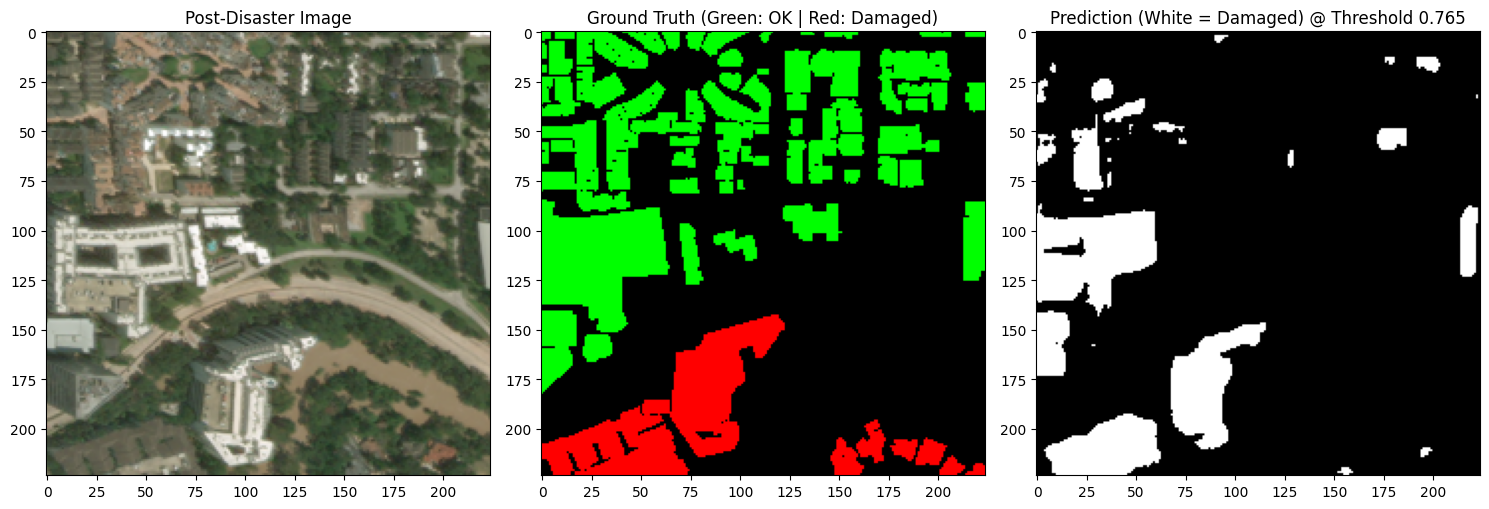

In [29]:
predict_and_show_from_paths(model, pre_path, post_path, original_mask_path, building_path, device)